# Validation/Verification & Performance comparison for MNIST digit classification with multiple hidden layers and multiple neurons

## CPU only

## Import stuff

In [41]:
import numpy as np
print('numpy',np.__version__)

import matplotlib.pyplot as plt


# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import Tanh_offset, Tanh_offset
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import visualize


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
print('tf',tf.__version__)

import torch, torchvision
print('torch',torch.__version__)
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

numpy 1.19.2
tf 2.2.3
torch 1.10.1


## Ensure that evertyhing is only using CPU

In [42]:
torch.cuda.is_available()

False

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [44]:
tf.test.is_gpu_available()

False

In [45]:
print(tf.test.is_built_with_cuda())

True


## Check if NumPy is linked with MKL or not

In [46]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Start with the common stuff

In [47]:
nInputs = 784
nSamples = nBatch = 32
nOutputs = 1
neurons_per_layer = [100,100,10]#[500,500,500,500,1]#[ 100,4,1] #[100,100,100,100,100,100,1]#[100,100,100,100,1]
activation_func_names = ['Sigmoid','Sigmoid', 'Softmax']#['sigmoid', 'sigmoid', 'sigmoid']#['sigmoid', 'sigmoid','sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']#['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid']
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10
nBatches = 0
batchSize = 200#nSamples
totSamples = 0

#### Activation function dictionary for all the frameworks

In [48]:
# act_func_dict = {'Sigmoid':Sigmoid,'ReLU':ReLU,'ELU':ELU, 'Hardshrink' : Hardshrink,'Hardsigmoid':Hardsigmoid,\
#                  'Hardtanh':Hardtanh,'Hardswish':Hardswish,'LeakyReLU':LeakyReLU,'LogSigmoid':LogSigmoid,\
#                  'Tanh':Tanh,'Softmax':Softmax,'Softmin':Softmin,'LogSoftmax':LogSoftmax,'Mish':Mish,\
#                  'Swish':Swish,'Exponential':Exponential}

act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}
# act_func_dict_tensorflow = {'Sigmoid':sigmoid,'ReLU':ReLU,'ELU':ELU, 'Hardshrink' : Hardshrink,'Hardsigmoid':Hardsigmoid,\
#                  'Hardtanh':Hardtanh,'Hardswish':Hardswish,'LeakyReLU':LeakyReLU,'LogSigmoid':LogSigmoid,\
#                  'Tanh':Tanh,'Softmax':Softmax,'Softmin':Softmin,'LogSoftmax':LogSoftmax,'Mish':Mish,\
#                  'Swish':Swish,'Exponential':exponential}



## Visualize 

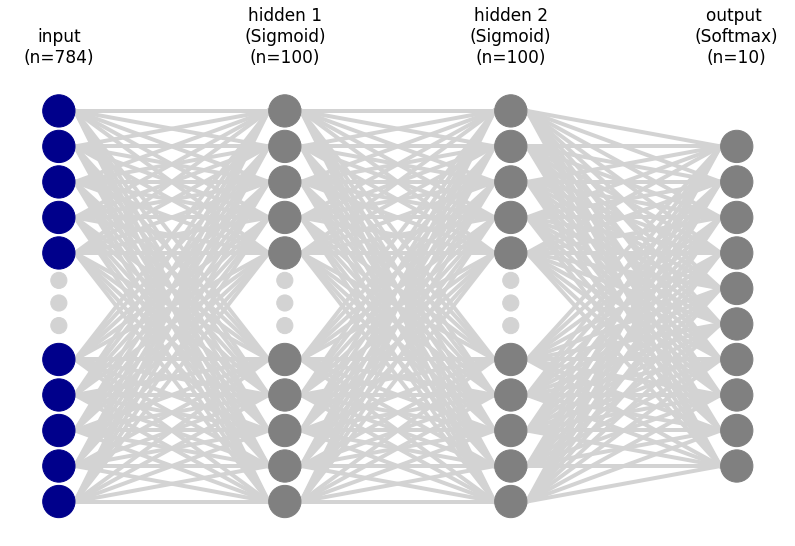

In [49]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Set inputs

Use torchvision to get the dataset, as well as form the input and output matrices for the learning.

In [50]:
fname = 'MNIST'

### Download and initialize datasets
TrainDS_orig = torchvision.datasets.MNIST(fname, train=True, download=True)
TestDS_orig = torchvision.datasets.MNIST(fname, train=False)

Plot few examples of the data

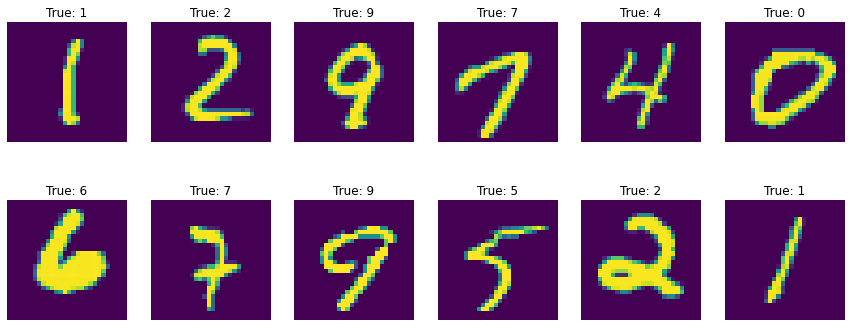

In [51]:
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i' % orig_label)

Currently the dataset is such that each element of `TrainDS_orig` returns an image and the output label(the digit)

<PIL.Image.Image image mode=L size=28x28 at 0x16BDA377F08>
5


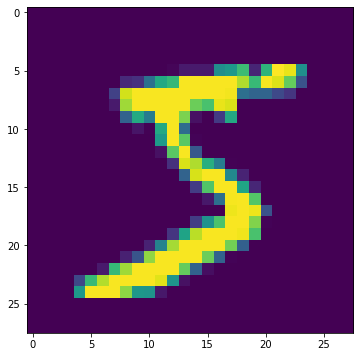

In [52]:
image, orig_label = TrainDS_orig[0]
print(image)
print(orig_label)
plt.imshow(image)

We can convert each image in the data to a 28x28 2d-array or a 784x1 1d-array manually as follows

In [53]:
imgData = np.array(image.getdata()) # Get data values
imgData = imgData/imgData.max() # Renormalize
print(imgData.shape)
imgData = np.reshape(imgData, [28,28]) # Reshape
print(imgData)
print(imgData.shape)

(784,)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        

But alternatively, we can just use PyTorch to do it, because we would want to have the same order of batches and everything to keep the benchmark consistent and comparable.

Also, instead of the output label being just a digit, it would be better if it is a 10x1 array with each element giving the probability of the classification being a digit in 0-9.

In [54]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(10)
    newlabel[inlabel] = 1.
    return newlabel

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.MNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.ToTensor())
TestDS = torchvision.datasets.MNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.ToTensor())

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=batchSize)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)

The `TrainDL` dataloader object holds everything we need (as tensors). We would now use it to get the input data and the output data as numpy 2d arrays for our implementation as well as for tf.eras

In [55]:
totSamples = 0
for inp, labels in TrainDL:
    totSamples = totSamples+1
nBatches = totSamples
print('Total no. of batches: ', totSamples)

totSamples = totSamples*batchSize
print('Total no. of training samples: ', totSamples)

Total no. of batches:  300
Total no. of training samples:  60000


## Actually create inputs and outputs

Create total inputs matrix and the total outputs matrix, which hold all the training data 

In [56]:
inputs = np.zeros((totSamples,784))
outputs = np.zeros((totSamples, 10))

i = 0
for inp, labels in TrainDL:
    offset = i*batchSize
    inputs[offset:offset + batchSize,:] = np.reshape(inp, (batchSize,784))
    outputs[offset:offset + batchSize,:] = labels

## Set float32 precision

In [57]:
inputs = inputs.astype('float32')
outputs = outputs.astype('float32')
print(inputs.dtype)
print(outputs.dtype)

float32
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [58]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [59]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [60]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.01238345 -0.05181954 -0.02637942 ...  0.02585154 -0.01972798
   0.06198199]
 [ 0.01671046  0.05567965 -0.02967516 ...  0.0732431  -0.05244204
  -0.0369852 ]
 [-0.00913788  0.02259503 -0.05689077 ...  0.0505306  -0.04258328
  -0.06218188]
 ...
 [-0.00580963  0.05517174  0.04271254 ... -0.01830812  0.01620933
   0.04818514]
 [ 0.06010145 -0.0230847  -0.01725645 ...  0.06668499 -0.03332334
   0.01279797]
 [-0.06046736  0.06935923 -0.01884871 ... -0.00659653  0.01581478
  -0.04621959]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

 Weights for layer  2
[[ 0.00293395  0.12964827  0.14578417 ...  0.12124008  0.07689646
  -0.01183742]
 [ 0.14139935  0.03276807 -0.11680634 ...  0.04060708

## Save the weights generated by tf.keras and use them for our implementation as well

In [61]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[ 0.01238345,  0.01671046, -0.00913788, ..., -0.00580963,
         0.06010145, -0.06046736],
       [-0.05181954,  0.05567965,  0.02259503, ...,  0.05517174,
        -0.0230847 ,  0.06935923],
       [-0.02637942, -0.02967516, -0.05689077, ...,  0.04271254,
        -0.01725645, -0.01884871],
       ...,
       [ 0.02585154,  0.0732431 ,  0.0505306 , ..., -0.01830812,
         0.06668499, -0.00659653],
       [-0.01972798, -0.05244204, -0.04258328, ...,  0.01620933,
        -0.03332334,  0.01581478],
       [ 0.06198199, -0.0369852 , -0.06218188, ...,  0.04818514,
         0.01279797, -0.04621959]], dtype=float32), array([[ 0.00293395,  0.14139935, -0.11709363, ...,  0.10545543,
        -0.05746631, -0.13363001],
       [ 0.12964827,  0.03276807, -0.145352  , ...,  0.17063716,
        -0.06060041, -0.01223303],
       [ 0.14578417, -0.11680634,  0.06291865, ...,  0.02516033,
        -0.069787  ,  0.14778149],
       ...,
       [ 0.12124008,  0.04060708, -0.09

## Compile model

In [62]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
# model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['binary_crossentropy'])
# model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['categorical_crossentropy'])



## Forward feed

In [63]:
model.evaluate(inputs, outputs, batch_size=batchSize)

300/300 [==============================] - 0s 943us/step - loss: 0.1085 - binary_crossentropy: 0.1085


[0.10848138481378555, 0.10848138481378555]

## Does tf.model.evaluate change the weights and biases?

In [64]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.01238345 -0.05181954 -0.02637942 ...  0.02585154 -0.01972798
   0.06198199]
 [ 0.01671046  0.05567965 -0.02967516 ...  0.0732431  -0.05244204
  -0.0369852 ]
 [-0.00913788  0.02259503 -0.05689077 ...  0.0505306  -0.04258328
  -0.06218188]
 ...
 [-0.00580963  0.05517174  0.04271254 ... -0.01830812  0.01620933
   0.04818514]
 [ 0.06010145 -0.0230847  -0.01725645 ...  0.06668499 -0.03332334
   0.01279797]
 [-0.06046736  0.06935923 -0.01884871 ... -0.00659653  0.01581478
  -0.04621959]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

 Weights for layer  2
[[ 0.00293395  0.12964827  0.14578417 ...  0.12124008  0.07689646
  -0.01183742]
 [ 0.14139935  0.03276807 -0.11680634 ...  0.04060708

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [65]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

300/300 [==============================] - 0s 1ms/step - loss: 0.1063 - binary_crossentropy: 0.1063


## Now the weights and biases must have been updated

In [66]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.01238345 -0.05181954 -0.02637942 ...  0.02585154 -0.01972798
   0.06198199]
 [ 0.01671046  0.05567965 -0.02967516 ...  0.0732431  -0.05244204
  -0.0369852 ]
 [-0.00913788  0.02259503 -0.05689077 ...  0.0505306  -0.04258328
  -0.06218188]
 ...
 [-0.00580963  0.05517174  0.04271254 ... -0.01830812  0.01620933
   0.04818514]
 [ 0.06010145 -0.0230847  -0.01725645 ...  0.06668499 -0.03332334
   0.01279797]
 [-0.06046736  0.06935923 -0.01884871 ... -0.00659653  0.01581478
  -0.04621959]]

 Biases for layer  1
[ 3.7194506e-04  2.7033995e-04 -6.1429375e-05 -1.0974962e-04
  1.2721802e-04  1.6081122e-04 -3.2113362e-04  4.3736023e-04
 -9.0437541e-05  2.4628954e-04  7.3198962e-06 -7.5592434e-05
  9.8747332e-05  3.6998864e-04  4.7402177e-04  1.9097641e-04
  1.7778503e-04  2.8888733e-06 -3.5952420e-05  1.9523079e-04
 -2.1871686e-04 -5.7833595e-04  8.6795783e-04 -4.1853473e-05
 -7.8919478e-04 -2.9411484e-04 -5.3883361e-04 -1.6476269e-04
 -2.6605270e-04 -4.1356412e-04 -2.13

## Now let us do a forward feed again and calculate the loss/error

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [67]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

300/300 [==============================] - 0s 1ms/step - loss: 0.1061 - binary_crossentropy: 0.1061
[0.10609430074691772, 0.10609430074691772]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [68]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=batchSizenSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

Wall time: 2.88 s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [69]:
history.history

{'loss': [0.106094129383564,
  0.10609407722949982,
  0.10609374940395355,
  0.10609385371208191,
  0.10609359294176102,
  0.10609326511621475,
  0.10609285533428192,
  0.10609277337789536,
  0.10609275102615356,
  0.10609231144189835],
 'binary_crossentropy': [0.106094129383564,
  0.10609407722949982,
  0.10609374940395355,
  0.10609385371208191,
  0.10609359294176102,
  0.10609326511621475,
  0.10609285533428192,
  0.10609277337789536,
  0.10609275102615356,
  0.10609231144189835]}

## Now also let us have a look at the predictions for the sake of the tutorial

In [70]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.10322404 0.10380472 0.09737696 ... 0.09791636 0.10521162 0.09913287]
 [0.09723884 0.10269603 0.09836112 ... 0.10252167 0.10387824 0.09849948]
 [0.09913795 0.10644599 0.09429888 ... 0.09869539 0.10452541 0.09960194]
 ...
 [0.10008661 0.10088041 0.10074423 ... 0.09824412 0.10025711 0.09850299]
 [0.10008661 0.10088041 0.10074423 ... 0.09824412 0.10025711 0.09850299]
 [0.10008661 0.10088041 0.10074423 ... 0.09824412 0.10025711 0.09850299]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [71]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_3_input:0", shape=(None, 784), dtype=float32)

 Outputs for layer  1
Tensor("dense_3/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  2
Tensor("dense_3/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  2
Tensor("dense_4/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  3
Tensor("dense_4/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  3
Tensor("dense_5/Identity:0", shape=(None, 10), dtype=float32)


In [72]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_3_input:0", shape=(None, 784), dtype=float32)

 Outputs for layer  1
Tensor("dense_3/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  2
Tensor("dense_3/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  2
Tensor("dense_4/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  3
Tensor("dense_4/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  3
Tensor("dense_5/Identity:0", shape=(None, 10), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [73]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 Outputs for layer  1
[[0.33173692 0.5319311  0.3527335  ... 0.525751   0.7653185  0.2984357 ]
 [0.4624023  0.65272397 0.34888756 ... 0.5381086  0.6276406  0.37742838]
 [0.41667303 0.4776185  0.38131738 ... 0.6535107  0.5018931  0.566973  ]
 ...
 [0.5000884  0.5000703  0.49997833 ... 0.50007045 0.49988887 0.5000461 ]
 [0.5000884  0.5000703  0.49997833 ... 0.50007045 0.49988887 0.5000461 ]
 [0.5000884  0.5000703  0.49997833 ... 0.50007045 0.49988887 0.5000461 ]]

 Inputs for layer  2
[[0.33173692 0.5319311  0.3527335  ... 0.525751   0.7653185  0.2984357 ]
 [0.4624023  0.65272397 0.34888756 ... 0.5381086  0.6276406  0.37742838]
 [0.41667303 0.4776185  0.38131738 ... 0.6535107  0.5018931  0.566973  ]
 ...
 [0.5000884  0.5000703  0.49997833 ... 0.50007045 0.49988887 0.5000461 ]
 [0.5000884  0.5000703  0.49997833 .

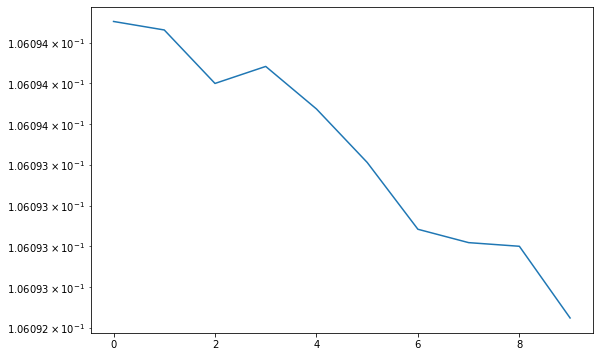

In [74]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [75]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0.32816297, 0.5358202 , 0.35052758, ..., 0.5203277 , 0.7674865 ,
        0.30467877],
       [0.46094128, 0.6543012 , 0.34787023, ..., 0.5328693 , 0.6291019 ,
        0.37905794],
       [0.41408202, 0.4792801 , 0.3800527 , ..., 0.6469483 , 0.50051415,
        0.56788695],
       ...,
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ]], dtype=float32), array([[0.41599947, 0.37748513, 0.4613252 , ..., 0.6420055 , 0.6524803 ,
        0.48401383],
      

## Backpropagation

In [76]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = MSE_loss_grad(a[nLayers], outputs)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 7.1784394e-05  1.6355902e-04  2.3563979e-04 ...  6.4907312e-05
  -8.5907662e-04  8.4007959e-05]
 [ 6.7595407e-05  1.6270830e-04  2.3683893e-04 ... -9.3219086e-04
   1.4006768e-04  8.3528823e-05]
 [ 6.9021604e-05  1.6870437e-04  2.2701157e-04 ...  6.5903972e-05
   1.4125012e-04  8.4894251e-05]
 ...
 [ 6.9014874e-05  1.5936737e-04  2.4179999e-04 ...  6.4737455e-05
   1.3584709e-04  8.2896346e-05]
 [ 6.9014874e-05  1.5936737e-04  2.4179999e-04 ...  6.4737455e-05
   1.3584709e-04  8.2896346e-05]
 [ 6.9014874e-05  1.5936737e-04  2.4179999e-04 ...  6.4737455e-05
   1.3584709e-04  8.2896346e-05]]
Gradient of Cost (error function) wrt weights:
 [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[-0.027

## Gradient descent (update the weights and biases)

In [77]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.01238345,  0.01671046, -0.00913788, ..., -0.00580963,
         0.06010145, -0.06046736],
       [-0.05181954,  0.05567965,  0.02259503, ...,  0.05517174,
        -0.0230847 ,  0.06935923],
       [-0.02637942, -0.02967516, -0.05689077, ...,  0.04271254,
        -0.01725645, -0.01884871],
       ...,
       [ 0.02585154,  0.0732431 ,  0.0505306 , ..., -0.01830812,
         0.06668499, -0.00659653],
       [-0.01972798, -0.05244204, -0.04258328, ...,  0.01620933,
        -0.03332334,  0.01581478],
       [ 0.06198199, -0.0369852 , -0.06218188, ...,  0.04818514,
         0.01279797, -0.04621959]], dtype=float32), array([[ 0.01671281,  0.15518086, -0.10332344, ...,  0.1192378 ,
        -0.04368099, -0.11985715],
       [ 0.13450466,  0.03762245, -0.14049804, ...,  0.17549436,
        -0.0557445 , -0.00737762],
       [ 0.157152  , -0.10544036,  0.07427942, ...,  0.03652213,
        -0.05841776,  0.15914813],
       ...,
       [ 0.13039878,  0.04976046, -0.0823932

## Forward feed again and check the loss/error

In [78]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0.32816297, 0.5358202 , 0.35052758, ..., 0.5203277 , 0.7674865 ,
        0.30467877],
       [0.46094128, 0.6543012 , 0.34787023, ..., 0.5328693 , 0.6291019 ,
        0.37905794],
       [0.41408202, 0.4792801 , 0.3800527 , ..., 0.6469483 , 0.50051415,
        0.56788695],
       ...,
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ]], dtype=float32), array([[0.41599947, 0.37748513, 0.4613252 , ..., 0.6420055 , 0.6524803 ,
        0.48401383],
      

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [79]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=BCE_loss, gradErrorFunc=BCE_loss_grad,miniterEpoch=1,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.10625278625034705
Wall time: 20.3 s


In [80]:
print(errorPlot)

[0.10625278625034705, 0.10609512173231775, 0.10609489804159256, 0.10609466434808656, 0.10609443085237331, 0.10609419823530658, 0.10609396489304415, 0.10609373195564031, 0.10609349962013466, 0.10609326624329342]


In [81]:
print(errorPlot)

[0.10625278625034705, 0.10609512173231775, 0.10609489804159256, 0.10609466434808656, 0.10609443085237331, 0.10609419823530658, 0.10609396489304415, 0.10609373195564031, 0.10609349962013466, 0.10609326624329342]


#### Test the quality of the weights by running a forward feed again

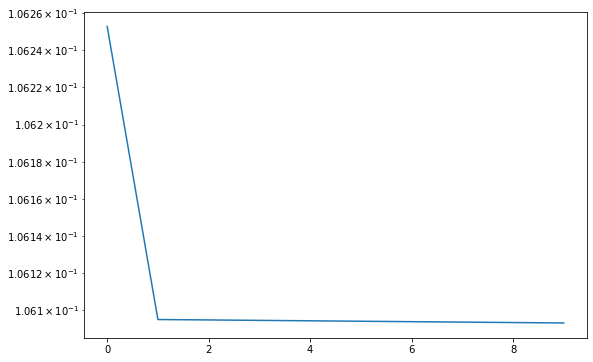

In [82]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [83]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.01238345,  0.01671046, -0.00913788, ..., -0.00580963,
         0.06010145, -0.06046736],
       [-0.05181954,  0.05567965,  0.02259503, ...,  0.05517174,
        -0.0230847 ,  0.06935923],
       [-0.02637942, -0.02967516, -0.05689077, ...,  0.04271254,
        -0.01725645, -0.01884871],
       ...,
       [ 0.02585154,  0.0732431 ,  0.0505306 , ..., -0.01830812,
         0.06668499, -0.00659653],
       [-0.01972798, -0.05244204, -0.04258328, ...,  0.01620933,
        -0.03332334,  0.01581478],
       [ 0.06198199, -0.0369852 , -0.06218188, ...,  0.04818514,
         0.01279797, -0.04621959]], dtype=float32), array([[ 0.00337443,  0.14178658, -0.11683298, ...,  0.1058531 ,
        -0.05709459, -0.13345064],
       [ 0.1298261 ,  0.03280962, -0.14523157, ...,  0.17064293,
        -0.06058695, -0.01206063],
       [ 0.1462767 , -0.1164979 ,  0.06312473, ...,  0.02517227,
        -0.069676  ,  0.14838476],
       ...,
       [ 0.12159804,  0.04081465, -0.0

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0.33154067, 0.53211874, 0.35169363, ..., 0.5266719 , 0.7642201 ,
        0.2992624 ],
       [0.46234816, 0.6527655 , 0.34827426, ..., 0.5385245 , 0.62670916,
        0.37776423],
       [0.4165241 , 0.47768995, 0.38074395, ..., 0.6535989 , 0.500806  ,
        0.5672151 ],
       ...,
       [0.5000853 , 0.50006753, 0.4999782 , ..., 0.5000717 , 0.49988982,
        0.5000489 ],
       [0.5000853 , 0.50006753, 0.4999782 , ..., 0.5000717 , 0.49988982,
        0.5000489 ],
       [0.5000853 , 0.50006753, 0.4999782 , ..., 0.5000717 , 0.49988982,
        0.5000489 ]], dtype=float32), array([[0.41876993, 0.38113046, 0.46501094, ..., 0.6497464 , 0.6623992 ,
        0.4752514 ],
      

In [84]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.0001587756
2.3212866e-05

Layer :  2
0.00017791986
8.0254045e-05

Layer :  3
0.0005145669
0.00054788403


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [85]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=BCE_loss, gradErrorFunc=BCE_loss_grad,miniterEpoch=1,batchProgressBar=True,miniterBatch=100)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.10625278626529684


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Wall time: 14.1 s


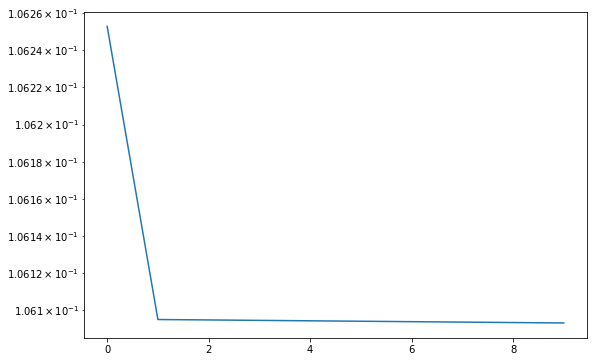

In [86]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [87]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.01238345,  0.01671046, -0.00913788, ..., -0.00580963,
         0.06010145, -0.06046736],
       [-0.05181954,  0.05567965,  0.02259503, ...,  0.05517174,
        -0.0230847 ,  0.06935923],
       [-0.02637942, -0.02967516, -0.05689077, ...,  0.04271254,
        -0.01725645, -0.01884871],
       ...,
       [ 0.02585154,  0.0732431 ,  0.0505306 , ..., -0.01830812,
         0.06668499, -0.00659653],
       [-0.01972798, -0.05244204, -0.04258328, ...,  0.01620933,
        -0.03332334,  0.01581478],
       [ 0.06198199, -0.0369852 , -0.06218188, ...,  0.04818514,
         0.01279797, -0.04621959]], dtype=float32), array([[ 0.00337442,  0.14178658, -0.11683293, ...,  0.1058531 ,
        -0.05709459, -0.13345063],
       [ 0.12982607,  0.03280962, -0.1452316 , ...,  0.17064291,
        -0.06058696, -0.01206062],
       [ 0.14627668, -0.11649791,  0.06312474, ...,  0.02517227,
        -0.069676  ,  0.14838478],
       ...,
       [ 0.12159802,  0.04081464, -0.0

Outputs at each layer (including input layer):
  [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0.3315407 , 0.5321187 , 0.35169372, ..., 0.5266719 , 0.7642201 ,
        0.2992624 ],
       [0.4623482 , 0.6527654 , 0.3482743 , ..., 0.5385245 , 0.62670904,
        0.37776423],
       [0.41652408, 0.47769   , 0.38074392, ..., 0.6535989 , 0.500806  ,
        0.5672151 ],
       ...,
       [0.5000853 , 0.50006753, 0.4999782 , ..., 0.5000717 , 0.49988982,
        0.5000489 ],
       [0.5000853 , 0.50006753, 0.4999782 , ..., 0.5000717 , 0.49988982,
        0.5000489 ],
       [0.5000853 , 0.50006753, 0.4999782 , ..., 0.5000717 , 0.49988982,
        0.5000489 ]], dtype=float32), array([[0.41877005, 0.38113037, 0.465011  , ..., 0.6497464 , 0.6623991 ,
        0.47525153],
      

In [88]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.0001587756
2.3211702e-05

Layer :  2
0.00017791986
8.0252416e-05

Layer :  3
0.000514552
0.00054785516


### BCE testing

In [90]:
X = torch.tensor([[1,0],[1,0],[0,1],[0,1]],dtype=torch.float)
softmaxTorch = torch.nn.Softmax(dim=1)


bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()
ce_loss= torch.nn.CrossEntropyLoss()

# My implementation of Softmax
pred = Softmax(X.cpu().detach().numpy())
print(pred)
# PyTorch implementation of Softmax
pred = softmaxTorch(X)
print(pred)


print(bce_loss(X,X)) # tensor(0.)
print(bce_loss(pred,X)) # tensor(0.3133)
print(bce_loss(pred,pred)) # tensor(0.5822)

print(ce_loss(X,torch.argmax(X,dim=1))) # tensor(0.3133)

# My implementation of cross entropy loss
# Note these will be Nsamples*PyTorch results as I don't return the average right away
print(BCE_loss(X.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(BCE_loss(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(BCE_loss(pred.cpu().detach().numpy(),pred.cpu().detach().numpy())/X.shape[0])

print(BCE_loss(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(errorFuncGrad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])

predX = torch.tensor(pred,dtype=torch.float,requires_grad=True)
loss = bce_loss(predX,X)
# loss = ce_loss(predX,torch.argmax(X,dim=1))
# loss = mse_loss(predX,X)
loss.backward()
print('gradient',predX.grad)
print(torch.autograd.grad(bce_loss(predX,X),predX))

%timeit BCE_loss(pred.cpu().detach().numpy(),pred.cpu().detach().numpy())
%timeit BCE_loss_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())
%timeit bce_loss(predX,X)

%timeit softmaxTorch(X)
%timeit Softmax(X.cpu().detach().numpy())

%timeit cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0]
%timeit cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0]

[[0.7310586  0.26894143]
 [0.7310586  0.26894143]
 [0.26894143 0.7310586 ]
 [0.26894143 0.7310586 ]]
tensor([[0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.2689, 0.7311],
        [0.2689, 0.7311]])
tensor(0.)
tensor(0.3133)
tensor(0.5822)
tensor(0.3133)
-4.991562718714704e-13
0.3132616819994708
0.5822031048526861
0.3132616819994708


NameError: name 'cross_entropy_grad' is not defined

# PyTorch

In [91]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [92]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [93]:
Network = torch.nn.Sequential(*Layers)

In [94]:
print(Network)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [95]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [96]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=100, out_features=100, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

## initial weights and biases generated by Pytorch

In [97]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[-0.0343, -0.0107, -0.0110,  ..., -0.0063,  0.0206, -0.0247],
        [-0.0124, -0.0050, -0.0277,  ..., -0.0064, -0.0085, -0.0035],
        [ 0.0279, -0.0092,  0.0265,  ...,  0.0100,  0.0290,  0.0091],
        ...,
        [ 0.0170, -0.0078, -0.0093,  ..., -0.0317, -0.0086, -0.0076],
        [ 0.0143, -0.0321,  0.0237,  ...,  0.0184,  0.0101,  0.0328],
        [ 0.0218,  0.0157,  0.0160,  ...,  0.0025,  0.0139,  0.0090]],
       requires_grad=True)
Parameter containing:
tensor([ 1.9712e-02, -7.7069e-03,  5.6711e-03, -4.6451e-05,  1.5210e-02,
        -1.5484e-02, -1.7288e-02, -1.7741e-02, -2.6412e-02, -2.8161e-02,
         2.8359e-02, -1.0997e-02,  2.7957e-02, -7.7915e-03, -1.8842e-02,
        -2.3935e-02, -1.3328e-02,  1.1470e-03, -2.5176e-02, -1.8210e-03,
         2.5304e-02, -1.8622e-02,  1.0855e-03,  2.2157e-02,  2.1198e-02,
        -7.9899e-03,  1.9892e-02,  9.4363e-03,  1.2133e-02,  1.9549e-02,
         2.2284e-02,  8.3039e-03,  2.0870e-02, -3.5560e-0

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [98]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [99]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 0.0124,  0.0167, -0.0091,  ..., -0.0058,  0.0601, -0.0605],
        [-0.0518,  0.0557,  0.0226,  ...,  0.0552, -0.0231,  0.0694],
        [-0.0264, -0.0297, -0.0569,  ...,  0.0427, -0.0173, -0.0188],
        ...,
        [ 0.0259,  0.0732,  0.0505,  ..., -0.0183,  0.0667, -0.0066],
        [-0.0197, -0.0524, -0.0426,  ...,  0.0162, -0.0333,  0.0158],
        [ 0.0620, -0.0370, -0.0622,  ...,  0.0482,  0.0128, -0.0462]])
Biases:

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
Weights:

tensor([[ 0.0029,  0.1414, -0.1171,  ...,  0.1055, -0.0575, -0.1336],
        [ 0.1296,  0.0328,

In [100]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.MSELoss()
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=100, out_features=100, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)
89610 trainable parameters


In [101]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [102]:
print(inputsTorch)
print(labels)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [103]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs+1)
errorPlot = []

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for iBatch in tqdm(range(nBatches),leave=False):
        offset = iBatch*batchSize
        inputsBatch = inputsTorch[offset:offset + batchSize,:]# Input vector
#            print(x.shape)
        labelsBatch = labels[offset:offset + batchSize,:] # Expected output
        
        opt.zero_grad() # zero gradient values
        inputsBatch = inputsBatch.to(device=device) # move input and label tensors to the device with the model
        labelsBatch = labelsBatch.to(device=device)
        outputsTorch = Network(inputsBatch) # compute model outputs
        loss = crit(outputsTorch, labelsBatch) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputsBatch) # add the batch loss to the running loss
        samples += len(inputsBatch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
    print(e, tr_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

1 0.10625278621912003


  0%|          | 0/300 [00:00<?, ?it/s]

2 0.10609512242178122


  0%|          | 0/300 [00:00<?, ?it/s]

3 0.10609489828348159


  0%|          | 0/300 [00:00<?, ?it/s]

4 0.10609466701745987


  0%|          | 0/300 [00:00<?, ?it/s]

5 0.10609443108240764


  0%|          | 0/300 [00:00<?, ?it/s]

6 0.10609419892231624


  0%|          | 0/300 [00:00<?, ?it/s]

7 0.10609396708508333


  0%|          | 0/300 [00:00<?, ?it/s]

8 0.1060937328884999


  0%|          | 0/300 [00:00<?, ?it/s]

9 0.10609350097676118


  0%|          | 0/300 [00:00<?, ?it/s]

10 0.10609326747556527
Wall time: 3.93 s


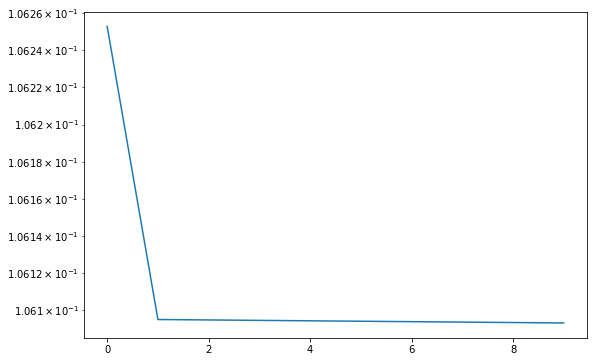

In [104]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [105]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(1.4901e-08)
tensor(2.3283e-09)

Layer :  2
tensor(1.3411e-07)
tensor(1.6997e-08)

Layer :  3
tensor(4.0233e-07)
tensor(1.1921e-07)


In [106]:
torch.get_num_threads()

8

In [ ]:
# torch.set_num_threads(4)
torch.get_num_threads()

In [ ]:
torch.get_num_threads()